In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

# File Paths
cleaned_drug_targets_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_updated_drug_targets.csv"
protein_embeddings_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/protein_embeddings.pt"
output_drug_embeddings_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_embeddings.pt"

# Load the cleaned drug targets and protein embeddings
drug_targets_df = pd.read_csv(cleaned_drug_targets_file)
protein_embeddings = torch.load(protein_embeddings_file)

# Initialize dictionary to store drug embeddings
drug_embeddings = {}

# Generate drug embeddings
for drug_id, group in tqdm(drug_targets_df.groupby("drug_id"), desc="Generating Drug Embeddings"):
    protein_ids = group["protein_id"].tolist()
    valid_embeddings = []

    # Collect protein embeddings for the drug
    for protein_id in protein_ids:
        if protein_id in protein_embeddings:
            valid_embeddings.append(protein_embeddings[protein_id])

    # If valid protein embeddings exist, aggregate them (mean-pooling)
    if valid_embeddings:
        aggregated_embedding = torch.mean(torch.stack(valid_embeddings), dim=0)
        drug_embeddings[drug_id] = aggregated_embedding
    else:
        print(f"No valid protein embeddings found for drug: {drug_id}")
        drug_embeddings[drug_id] = None  # Optional: Mark as None if no embeddings are found

# Save drug embeddings to file
torch.save(drug_embeddings, output_drug_embeddings_file)
print(f"Drug embeddings saved to {output_drug_embeddings_file}")

# Display a few sample drug embeddings
print("Sample Drug Embeddings:")
sample_drugs = list(drug_embeddings.keys())[:5]
for drug_id in sample_drugs:
    if drug_embeddings[drug_id] is not None:
        print(f"Drug ID: {drug_id}, Embedding Shape: {drug_embeddings[drug_id].shape}")
    else:
        print(f"Drug ID: {drug_id}, Embedding: None")


<ipython-input-2-c29ba5da54fa>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  protein_embeddings = torch.load(protein_embeddings_file)
Generating Drug Embeddings: 100%|██

Drug embeddings saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_embeddings.pt
Sample Drug Embeddings:
Drug ID: DB00001, Embedding Shape: torch.Size([1024])
Drug ID: DB00002, Embedding Shape: torch.Size([1024])
Drug ID: DB00004, Embedding Shape: torch.Size([1024])
Drug ID: DB00005, Embedding Shape: torch.Size([1024])
Drug ID: DB00006, Embedding Shape: torch.Size([1024])


### Validation

In [ ]:
import torch
import pandas as pd

# File paths
cleaned_drug_targets_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_updated_drug_targets.csv"
drug_embeddings_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/drug_embeddings.pt"
missing_drugs_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/missing_drug_embeddings.csv"

# Load data
drug_targets_df = pd.read_csv(cleaned_drug_targets_file)
drug_embeddings = torch.load(drug_embeddings_file)

# Get unique drug IDs from the targets file
drug_ids_in_file = set(drug_targets_df["drug_id"].unique())

# Get drug IDs from the embeddings file
drug_ids_in_embeddings = set(drug_embeddings.keys())

# Find missing drugs
missing_drugs = drug_ids_in_file - drug_ids_in_embeddings
print(f"Total drugs in drug targets file: {len(drug_ids_in_file)}")
print(f"Total drugs in embeddings file: {len(drug_ids_in_embeddings)}")
print(f"Missing drugs: {len(missing_drugs)}")

# Save missing drugs to CSV
if missing_drugs:
    pd.DataFrame(list(missing_drugs), columns=["drug_id"]).to_csv(missing_drugs_file, index=False)
    print(f"Missing drugs saved to {missing_drugs_file}")
else:
    print("All drugs have embeddings!")


<ipython-input-3-6577524463a5>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  drug_embeddings = torch.load(drug_embeddings_file)


Total drugs in drug targets file: 7793
Total drugs in embeddings file: 7793
Missing drugs: 0
All drugs have embeddings!


### Visualisations

<ipython-input-4-cc79d1630a0d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  drug_embeddings = torch.load(drug_embeddings_file)


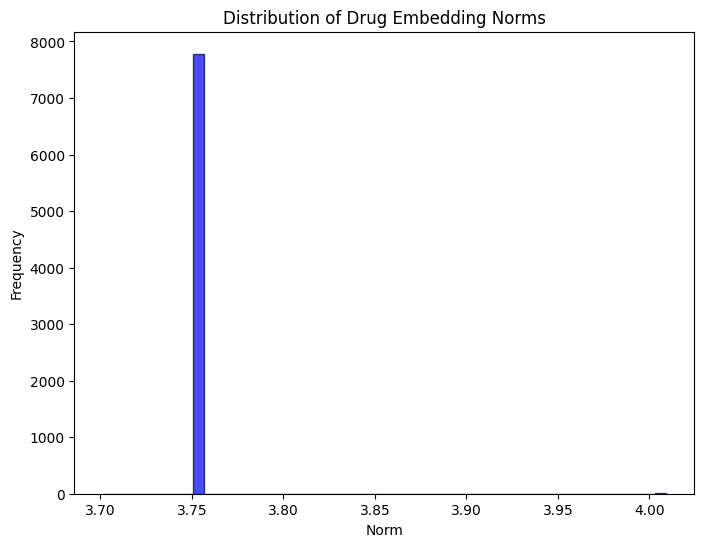

In [ ]:
import torch
import matplotlib.pyplot as plt

# Load drug embeddings
drug_embeddings = torch.load(drug_embeddings_file)

# Calculate norms
norms = [torch.norm(embedding).item() for embedding in drug_embeddings.values()]

# Plot
plt.figure(figsize=(8, 6))
plt.hist(norms, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("Distribution of Drug Embedding Norms")
plt.xlabel("Norm")
plt.ylabel("Frequency")
plt.show()


### K-Means Clustering on T-SNE Projected Data

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


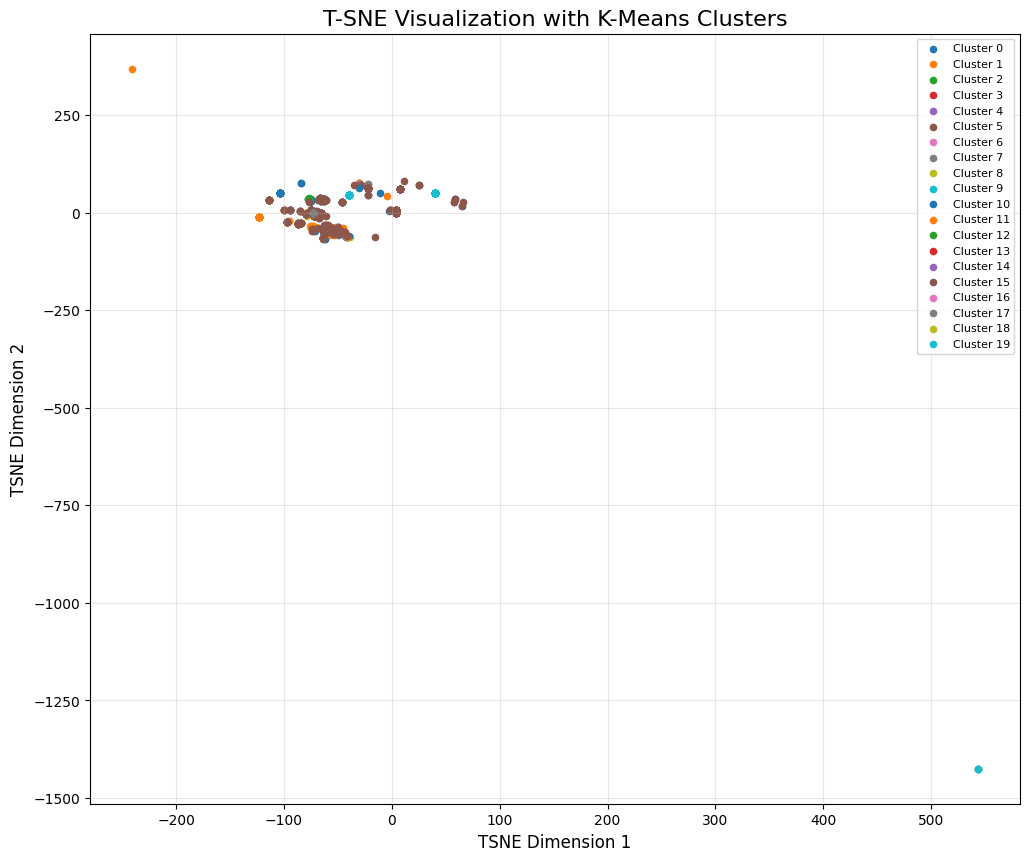

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
drug_ids = list(drug_embeddings.keys())
embeddings = torch.stack(list(drug_embeddings.values())).numpy()

# Assuming 'embeddings' is a NumPy array or tensor with drug embeddings
# Convert embeddings to a NumPy array if it's a PyTorch tensor
embeddings_array = embeddings if isinstance(embeddings, np.ndarray) else embeddings.numpy()

# Step 1: Reduce dimensionality using T-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings_array)

# Step 2: Perform K-Means Clustering
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings_array)

# Step 3: Visualize T-SNE with Cluster Labels
plt.figure(figsize=(12, 10))
for cluster_id in range(num_clusters):
    # Select points belonging to the current cluster
    cluster_points = embeddings_2d[clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", s=20)

# Add titles and legends
plt.title("T-SNE Visualization with K-Means Clusters", fontsize=16)
plt.xlabel("TSNE Dimension 1", fontsize=12)
plt.ylabel("TSNE Dimension 2", fontsize=12)
plt.legend(loc="upper right", fontsize=8)
plt.grid(alpha=0.3)
plt.show()



### Pairwise Drug Similarity Heatmap

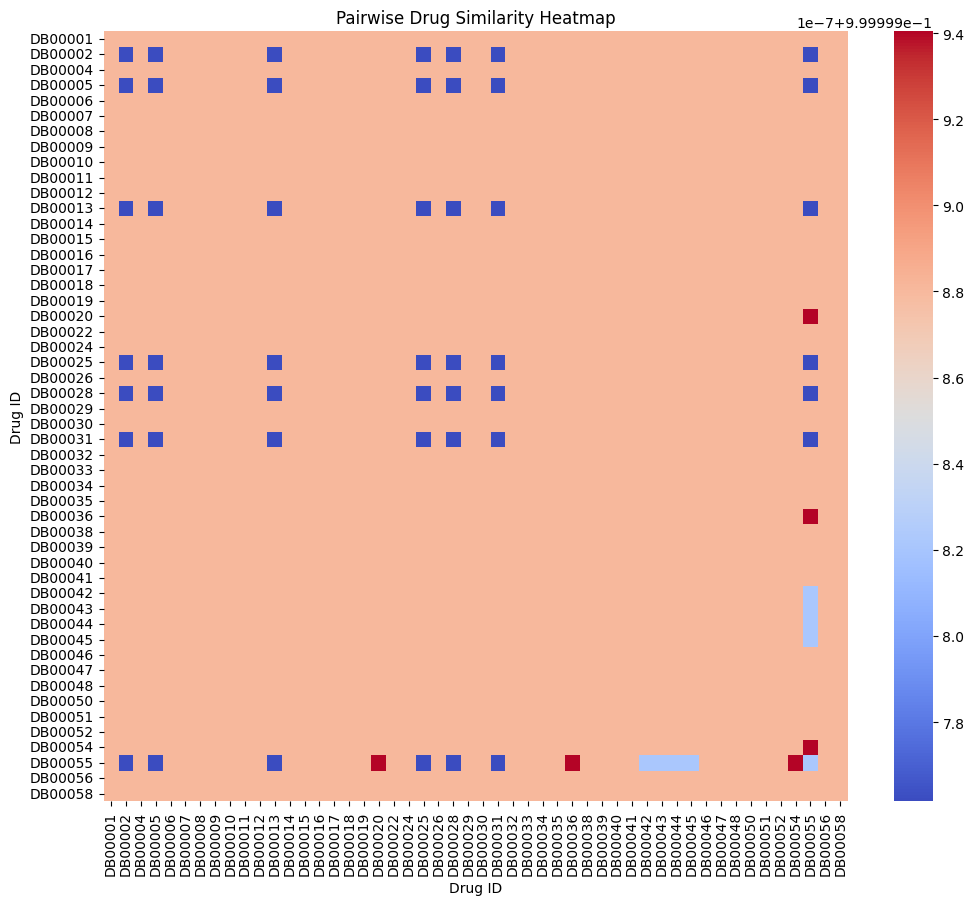

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import numpy as np

# Compute pairwise similarity
similarity_matrix = cosine_similarity(embeddings[:50])  # Limit to first 50 drugs for clarity

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_matrix, xticklabels=drug_ids[:50], yticklabels=drug_ids[:50], cmap="coolwarm")
plt.title("Pairwise Drug Similarity Heatmap")
plt.xlabel("Drug ID")
plt.ylabel("Drug ID")
plt.show()


### Network Graph of Drug Similarity

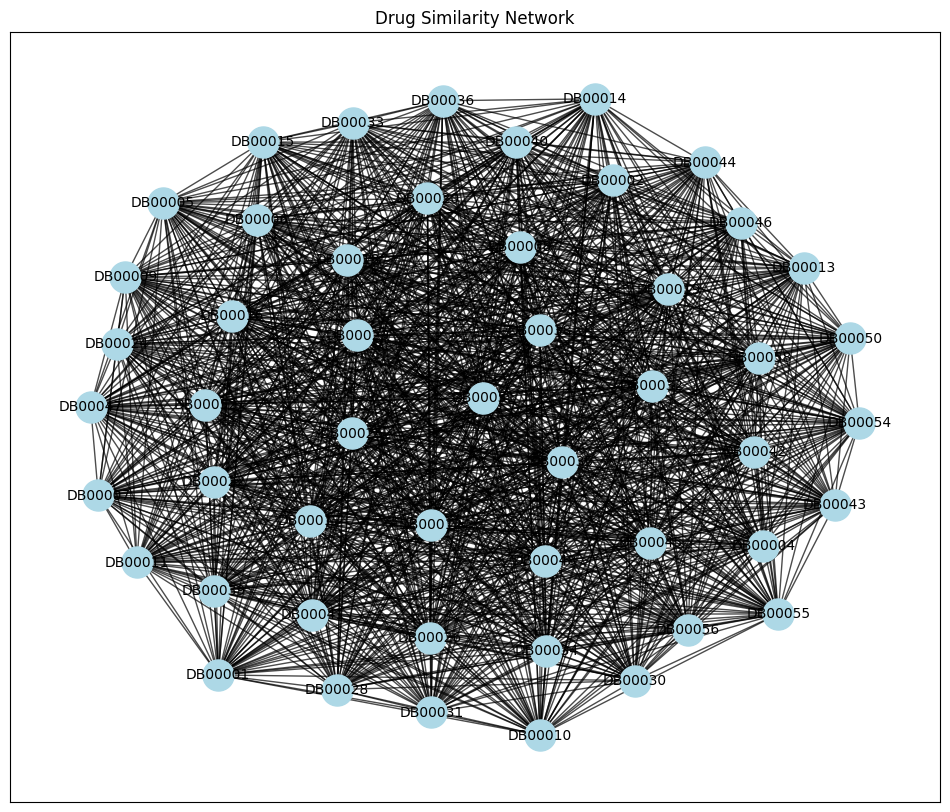

In [ ]:
import networkx as nx

# Create a graph
threshold = 0.9  # Only show strong similarities
graph = nx.Graph()

for i, drug1 in enumerate(drug_ids[:50]):  # Limit to first 50 drugs for clarity
    for j, drug2 in enumerate(drug_ids[:50]):
        if i != j and similarity_matrix[i, j] > threshold:
            graph.add_edge(drug1, drug2, weight=similarity_matrix[i, j])

# Draw graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(graph)
nx.draw_networkx_nodes(graph, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.7)
nx.draw_networkx_labels(graph, pos, font_size=10)
plt.title("Drug Similarity Network")
plt.show()


### PCA: Variance Explained by Embedding Components

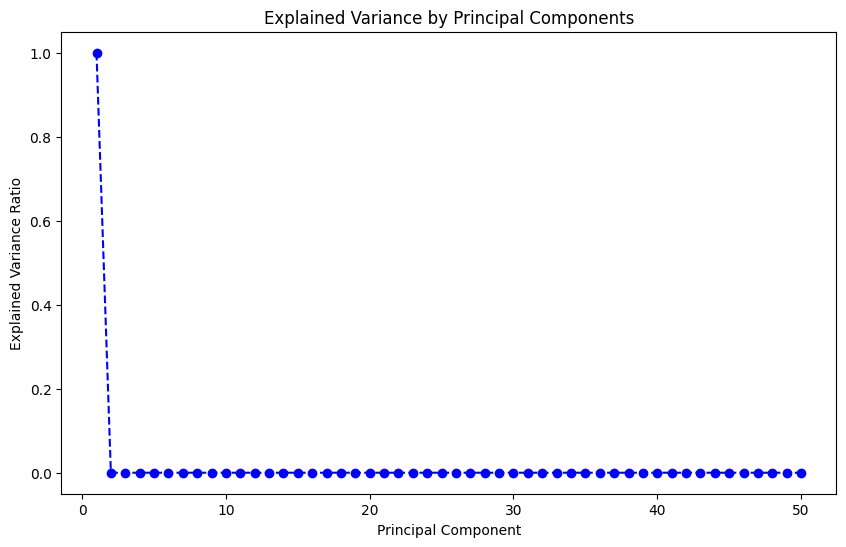

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

embedding_matrix = np.stack([embedding.numpy() for embedding in drug_embeddings.values()])


# Perform PCA
pca = PCA(n_components=50)  # Analyze the first 50 components
pca.fit(embedding_matrix)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), pca.explained_variance_ratio_, marker='o', linestyle='--', color='blue')
plt.title("Explained Variance by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.show()
